<a href="https://colab.research.google.com/github/aneekbsws/deeplearning/blob/main/deep_nn_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

#Some pre-processing#

Sigmoid and RELU Functions

In [ ]:
def sigmoid(Z):
  A = 1/(1+np.exp(-Z))
  cache = Z # Storing Z as a cache (to help moving forward)
  return A,cache

def relu(Z):
  A = np.maximum(0,Z)
  cache = Z  # Storing Z as a cache (to help moving forward)
  return A,cache

Derivatives of the sigmoid and relu functions (g'(Z))

In [ ]:
def dg_sigmoid(dA, cache):
  Z = cache # Since cache has only Z
  S = 1/(1+np.exp(-Z))
  dZ = dA *S*(1 - S)   
  return dZ

def dg_relu(dA, cache):
  Z = cache  # Since cache has only Z
  dZ = np.array(dA, copy=True)
  dZ[Z<=0] = 0
  return dZ

#Setting up the stage#

Initializing the initial parameters (w,b)

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
  W1 = np.random.randn(n_h, n_x)*0.01
  b1 = np.zeros((n_h,1))
  W2 = np.random.randn(n_y, n_h)*0.01
  b2 = np.zeros((n_y,1))
  parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
  return parameters

Initializing the parameters (W,b) for inner layers

In [ ]:
def initialize_inner_parameters(layers_dim):
    #layers_dim is the number of hidden layers [n_1 n_2 n_3 n_4...n_L] where each
    #n_l corresponds to number of units in each layer
  parameters = {} 
    #Parameters in the initialize_parameters function was used to
    #hold W1, b1, W2, b2
  L = len(layers_dim)
  for l in range(1,L): 
    parameters["W"+str(l)] = np.random.randn(layers_dim[l],layers_dim[l-1])/np.sqrt(layers_dim[l-1])
    parameters["b"+str(l)] = np.zeros((layers_dim[l],1))
  return parameters

#Forward Propagation Functions#

***Linear and activation (relu/sigmoid) for L-1 layers and a sigmoid for Lth (last) layer***

Linear Function

In [ ]:
def forward_prop_single_linear(A,W,b):
  Z = np.dot(W,A)+b
  cache = (A,W,b) #Storing the A, W and b for backward propagation as list
  return Z, cache

Fetching the linear result and applying activation function onto it

In [ ]:
def forward_prop_single_activation(A_prev, W, b, activation):
  if activation == 'relu':
    Z, linear_cache = forward_prop_single_linear(A_prev, W,b) #Linear_Cache stores the Z used in linear function
    A, activation_cache = relu(Z) #Activation_Cache stores the Z used in activation function
  elif activation == 'sigmoid':
    Z, linear_cache = forward_prop_single_linear(A_prev, W,b) #Linear_Cache stores the A,W,B used in linear function
    A, activation_cache = sigmoid(Z) #Activation_Cache stores the Z used in activation function    
  cache = (linear_cache, activation_cache)
  return A, cache

Implementing these two functions across L number of layers

In [ ]:
def foward_prop_Llayers(X, parameters):
  caches = [] # A list containing (linear_cache(A,W,B), activation_cache(Z)) of every layer going forward
  A = X #Initially, A[0] is nothing but the input itself.
  L = len(parameters)//2 #Floor division #Since parameters is a dictionary containing W and b values for all layers
  for l in range(1,L):
    A_prev = A
    A, cache = forward_prop_single_activation(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation = 'relu')
    caches.append(cache)
  # Now for the very last hidden - output connection - applying a sigmoid function
  AL, cache = forward_prop_single_activation(A, parameters["W"+str(L)], parameters["b"+str(L)], activation = 'sigmoid')
  caches.append(cache)
  return AL, caches

Finding the cost

In [ ]:
def compute_cost(AL, Y):
  m = Y.shape[1]
  cost = cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
  cost = np.squeeze(cost) #np.squeeze converts [[x]] into x
  return cost

# Backward Propagation Functions#

 ***Linear and activation (relu/sigmoid) for L-1 layers and a sigmoid for Lth (last)***

Linear Function using dZ to find dA, dW, db

In [ ]:
def backward_prop_single_linear(dZ, cache):
  #cache here is the cache of the linear backward propagation
  A_prev, W, b = cache[0]
  m = A_prev.shape[1]
  dW = 1./m * np.dot(dZ,A_prev.T)
  db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
  dA_prev = np.dot(W.T,dZ)
  return dA_prev, dW, db 

Including activation function's derivative and hence, finding dZ - using it to find dA, dW, db

In [ ]:
def backward_prop_single_activation(dA, cache, activation):
  # here cache is the (linear_cache (A,w,b) and activation_cache(Z))
  linear_cache, activation_cache = cache
  if activation == 'relu':
    dZ = dg_relu(dA, activation_cache)
    dA_prev, dW, db = backward_prop_single_linear(dZ, cache)
  elif activation == 'sigmoid':
    dZ = dg_sigmoid(dA, activation_cache)
    dA_prev, dW, db = backward_prop_single_linear(dZ, cache)
  return dA_prev, dW, db

Implementing these two functions across L number of layers

In [ ]:
def backward_prop_Llayer(AL, Y, caches):
  # cache = (linear_cache, activation_cache) of each and every layer
  # Each cache of each layer is a tuple of tuples = ((A,W,b),Z)
  grads = {}
  L = len(caches) 
  m = AL.shape[1] # AL is in shape (n_h, m)
  Y = Y.reshape(AL.shape) # Just ensuring they are of same shape
  current_caches = caches[L-1] # caches[L-1] is the tuple for last layer 
  dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL)) # Finding the initial dAL
  da_prev_temp, dW_temp, db_temp = backward_prop_single_activation(dAL, current_caches,activation = 'sigmoid') # Finding dA(L-1), dWL, dbL, dZL 
  grads["dA"+str(L-1)] = da_prev_temp 
  grads["dW"+str(L)] = dW_temp
  grads["db"+str(L)] = db_temp
  for l in reversed(range(L-1)):
    current_caches = caches[l] # Setting each corresponding cache to a dummy tuple
    dA_prev_temp, dW_temp, db_temp = backward_prop_single_activation(grads["dA"+str(l+1)], current_caches, activation = 'relu') #caches
    grads["dA"+str(l)] = dA_prev_temp
    grads["dW"+str(l+1)] = dW_temp
    grads["db"+str(l+1)] = db_temp
  return grads

Updating the parameters

In [ ]:
def update_parameters(params, grads,learning_rate):
  parameters = params.copy() # These are the initially assigned W and b
  L = len(parameters)//2
  for l in range(L):
    parameters["W"+str(l+1)] =  parameters["W"+str(l+1)] - (learning_rate*grads["dW"+str(l+1)])
    parameters["b"+str(l+1)] =  parameters["b"+str(l+1)] - (learning_rate*grads["db"+str(l+1)])
  return parameters

#Predicting images



Loading data

In [ ]:
def load_data():
    train_dataset = h5py.File('train_catvnoncat_NN.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat_NN.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
X_train, y_train, X_test, y_test, classes = load_data()

Exploring dataset

In [ ]:
print(X_train.shape)
m_train = X_train.shape[0] # Number of training examples
num_px = X_train.shape[1] # Number of parameters
m_test = X_test.shape[0]
print("Number of training examples : ",m_train)
print("Number of parameters : ",num_px)
print("Number of test examples : ",m_test)

(209, 64, 64, 3)
Number of training examples :  209
Number of parameters :  64
Number of test examples :  50


Reshaping the training and test sets

In [ ]:
# Currently the sets are in shape (m_train, num_px, num_px, 3). it now needs to be (num_px^2*3,m_train)
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T 
# Converts it to (m_train, num_px^2*3). -1 is used to flatten the remaining dimensions
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T
X_train_final = X_train_flatten/255.
X_test_final = X_test_flatten/255.
print(X_train_final.shape)
print(X_test_final.shape)

(12288, 209)
(12288, 50)


Constants defining the model

In [ ]:
n_x = X_train_flatten.shape[0]
n_h = 7
n_y = 1
layers_dim = (n_x, n_h, n_y)
print(layers_dim)
learning_rate = 0.0075

(12288, 7, 1)


Experimenting a 2-Layer NN

In [ ]:
def two_layer_nn(X,Y, layers_dim, num_iterations, print_cost):
  
  grads = {}
  costs = []
  m = X.shape[1]
  (n_x, n_h, n_y) = layers_dim
  print(layers_dim)
  # print("n_x",n_x)
  # print("n_h",n_h)
  # print("n_y",n_y)
  parameters = initialize_parameters(n_x, n_h, n_y)
  # print(parameters)
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  print("X:",X.shape)
  print("W1:", W1.shape)
  print("W2:", W2.shape)
  print("b1:", b1.shape)
  print("b2:", b2.shape)
  print("Y:",Y.shape)
  # Looping through
  for i in range(0, num_iterations):
    
    #Forward propagation
    A1, cache1 =  forward_prop_single_activation(X, W1, b1, activation = 'relu')
    A2, cache2 =  forward_prop_single_activation(A1, W2, b2, activation = 'sigmoid')
    cost = compute_cost(A2, Y)
    
    #Backward propagation
    dA2 = -(np.divide(Y,A2) - np.divide(1-Y,1-A2))
    dA1, dW2, db2 = backward_prop_single_activation(dA2, cache2, 'sigmoid')
    dA0, dW1, db1 = backward_prop_single_activation(dA1, cache1, 'relu')
    grads["dW1"] = dW1
    grads["db1"] = db1
    grads["dW2"] = dW2
    grads["db2"] = db2
    parameters = update_parameters(parameters, grads, learning_rate)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    if print_cost and i % 100 == 0 or i == num_iterations - 1:
      # print(X.shape)
      # print(Y.shape)
      # print(A1)
      print("ITERATION :::: ",i)
      print("Cost after iteration {}: {}".format(i, cost))
      # print(parameters)
      # print(W1.shape, "; ",W2.shape)
    if i % 100 == 0 or i == num_iterations:
      costs.append(cost)
  return parameters,costs

In [ ]:
print(n_x)
print(n_h)
print(n_y)

12288
7
1


In [ ]:
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Training the model

(12288, 7, 1)
X: (12288, 209)
W1: (7, 12288)
W2: (1, 7)
b1: (7, 1)
b2: (1, 1)
Y: (1, 209)
ITERATION ::::  0
Cost after iteration 0: 0.6909088566164634
ITERATION ::::  100
Cost after iteration 100: 0.6474611745084954
ITERATION ::::  200
Cost after iteration 200: 0.6352352419024014
ITERATION ::::  300
Cost after iteration 300: 0.6071590105200444
ITERATION ::::  400
Cost after iteration 400: 0.5683119565815855
ITERATION ::::  500
Cost after iteration 500: 0.5277459857226342
ITERATION ::::  600
Cost after iteration 600: 0.485785548804639
ITERATION ::::  700
Cost after iteration 700: 0.4472975706579854
ITERATION ::::  800
Cost after iteration 800: 0.39889816392500177
ITERATION ::::  900
Cost after iteration 900: 0.3785097844939123
ITERATION ::::  1000
Cost after iteration 1000: 0.36705757469953004
ITERATION ::::  1100
Cost after iteration 1100: 0.32978824504535614
ITERATION ::::  1200
Cost after iteration 1200: 0.29637899570716014
ITERATION ::::  1300
Cost after iteration 1300: 0.2425256631

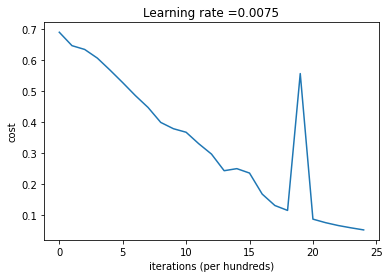

In [ ]:
parameters, costs = two_layer_nn(X_train_final, y_train, layers_dim=(n_x, n_h, n_y), num_iterations=2500, print_cost=True)
plot_costs(costs, learning_rate)

Predicting result:

In [ ]:
def predict(X,y,parameters):
  m = X.shape[1]
  n = len(parameters)//2
  print(n)
  p = np.zeros((1,m))
  AL, caches = foward_prop_Llayers(X, parameters)
  for i in range(0, AL.shape[1]):
    if(AL[0,i] > 0.5):
      p[0,i] = 1
    else:
      p[0,i] = 0
  print(p)
  print(y)
  print("Accuracy: "+str(np.sum((p==y)/m)))
  return p

In [ ]:
prediction_train = predict(X_train_final, y_train, parameters)

2
Accuracy: 0.9999999999999998


In [ ]:
prediction_test = predict(X_test_final, y_test, parameters)

2
Accuracy: 0.66


#Implementing the same solution with a 4-layer model#

Function for L-layer model

In [ ]:
def L_Layer_model(X,Y, layers_dims, num_iterations, print_cost):
  costs = []
  parameters = initialize_inner_parameters(layers_dim=layers_dims)
  for i in range(0, num_iterations):
    AL, caches = foward_prop_Llayers(X, parameters)
    cost = compute_cost(AL, Y)
    grads = backward_prop_Llayer(AL, Y, caches)
    parameters = update_parameters(parameters, grads,learning_rate)
    if print_cost and i % 100 == 0 or i == num_iterations - 1:
      print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    if i % 100 == 0 or i == num_iterations:
      costs.append(cost)
  return parameters, costs

In [ ]:
layers_dims = [12288, 20, 7, 5, 1]

In [ ]:
parameters, costs = L_Layer_model(X_train_final, y_train, layers_dims,num_iterations=3000,print_cost=True)

Cost after iteration 0: 0.6774649326723386
Cost after iteration 100: 0.5499418529141228
Cost after iteration 200: 0.48375333136343723
Cost after iteration 300: 0.4200128904435797
Cost after iteration 400: 0.32237636405572534
Cost after iteration 500: 0.3008426469410233
Cost after iteration 600: 0.1724397180943504
Cost after iteration 700: 0.10638211028222186
Cost after iteration 800: 0.07936559959584792
Cost after iteration 900: 0.053753644492001706
Cost after iteration 1000: 0.08389555186169348
Cost after iteration 1100: 0.04719671049995895
Cost after iteration 1200: 0.027894610535444193
Cost after iteration 1300: 0.01995389324080253
Cost after iteration 1400: 0.01516951643952492
Cost after iteration 1500: 0.012037230944744261
Cost after iteration 1600: 0.009846218415702674
Cost after iteration 1700: 0.008279680655633741
Cost after iteration 1800: 0.007092217623132917
Cost after iteration 1900: 0.0061683866549556415
Cost after iteration 2000: 0.005439610445953432
Cost after iteration 

Predicting Results

In [ ]:
p = predict(X_train_final,y_train,parameters)

4
Accuracy: 0.9999999999999998


In [ ]:
p_test = predict(X_test_final, y_test, parameters) 

4
Accuracy: 0.78


Predicting a custom image

In [ ]:
import scipy
from PIL import Image
from scipy import ndimage

In [ ]:
print(parameters)

64
(12288, 1)
4
[[0.]]
[1]
Accuracy: 0.0
[b'non-cat' b'cat']
y = 0.0, your L-layer model predicts a "non-cat" picture.


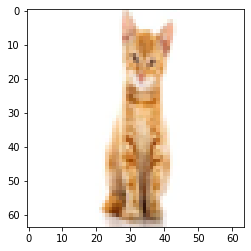

In [ ]:
## START CODE HERE ##
my_image = "cat3.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = my_image
print(num_px)
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
print(image.shape)
my_predicted_image = predict(image, my_label_y, parameters)
# print(my_predicted_image)
print(classes)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")